参考: https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

まずデータをダウンロードしてきます。

In [9]:
! wget https://download.pytorch.org/tutorial/data.zip -P ./../data/
! unzip ./../data/data.zip -d ./../data/

--2020-05-03 19:05:25--  https://download.pytorch.org/tutorial/data.zip
download.pytorch.org (download.pytorch.org) をDNSに問いあわせています... 2600:9000:208e:3800:d:607e:4540:93a1, 2600:9000:208e:c00:d:607e:4540:93a1, 2600:9000:208e:f400:d:607e:4540:93a1, ...
download.pytorch.org (download.pytorch.org)|2600:9000:208e:3800:d:607e:4540:93a1|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 2882130 (2.7M) [application/zip]
`./../data/data.zip' に保存中

data.zip            100%[===================>]   2.75M  14.6MB/s 時間 0.2s       

2020-05-03 19:05:25 (14.6 MB/s) - `./../data/data.zip' へ保存完了 [2882130/2882130]



データはlanguage/のディレクトリ に入れました。\[言語\].txtの形式で入れています。  
各ファイルには名前がいっぱい入っていて、1行につき1つで、ローマ字で入っています。  
UnicodeからASCIIに変換する必要があります。  
{言語: 名前}の辞書を作ります。

In [11]:
from io import open
import glob
import os

# ファイル・文字列操作

In [12]:
def findFiles(path): # ファイルを探す関数
    return glob.glob(path)

print(findFiles("./../data/language/names/*.txt"))

import unicodedata
import string

all_letters=string.ascii_letters+" .,;'" # 全ての文字
n_letters=len(all_letters) # 全ての文字の数

# Unicodeの文字をASCIIに変更する
# 参考: https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(c  for c in unicodedata.normalize("NFD",s) if unicodedata.category(c)!="Mn" and c in all_letters)

print(unicodeToAscii('Ślusàrski'))

### 辞書を作る
category_lines={} # 言語→行のリスト
all_categories=[] # 言語のリスト

# ファイルを読み込んで行に分割する関数
def readLines(filename):
    lines=open(filename,encoding="utf-8").read().strip().split("\n")
    
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles("./../data/language/names/*.txt"): # 各ファイルについて処理
    category=os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines=readLines(filename)
    category_lines[category]=lines
    
n_categories=len(all_categories) # カテゴリの数

['./../data/language/names/Czech.txt', './../data/language/names/German.txt', './../data/language/names/Arabic.txt', './../data/language/names/Japanese.txt', './../data/language/names/Chinese.txt', './../data/language/names/Vietnamese.txt', './../data/language/names/Russian.txt', './../data/language/names/French.txt', './../data/language/names/Irish.txt', './../data/language/names/English.txt', './../data/language/names/Spanish.txt', './../data/language/names/Greek.txt', './../data/language/names/Italian.txt', './../data/language/names/Portuguese.txt', './../data/language/names/Scottish.txt', './../data/language/names/Dutch.txt', './../data/language/names/Korean.txt', './../data/language/names/Polish.txt']
Slusarski


In [17]:
print(all_categories)
print(n_categories)
print(category_lines["Japanese"][:10])

['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
18
['Abe', 'Abukara', 'Adachi', 'Aida', 'Aihara', 'Aizawa', 'Ajibana', 'Akaike', 'Akamatsu', 'Akatsuka']


# テンソルへの変換

それでは名前の辞書やリストをテンソルに変換していきましょう。  
1文字を(1\*n_letters)のone-hotに変換しましょう。  
これらを2次元の行列、(line_length\*1\*n_letters)の形式に変換します。  
ここで1とはバッチサイズです。

In [18]:
import torch

# 文字をインデックスに変換する関数
def letterToIndex(letter):
    return all_letters.find(letter)

# デモンストレーションのために、文字を(1\*n_letters)のテンソルに変換する関数
def letterToTensor(letter):
    tensor=torch.zeros(1,n_letters)
    tensor[0][letterToIndex(letter)]=1
    
    return tensor

# 各行を(line_length*1*n_letters)のone-hotに変換する関数
def lineToTensor(line):
    tensor=torch.zeros(len(line),1,n_letters)
    
    for li,letter in enumerate(line): # 各行について
        tensor[li][0][letterToIndex(letter)]=1 # one-hot作成
        
    return tensor

print(letterToTensor("J"))
print(lineToTensor("Jones").size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


# ネットワークを構築

torchのRNNを使えます。各レイヤにはhidden stateがあります。  
このモジュールは2層の線形のレイヤです。入力と隠れ層と、そして出力にLogSoftmaxの層があります。

<img src="./rnn.png" width=350>

In [19]:
import torch.nn as nn

class RNN(nn.Module): # RNN
    def __init__(self,input_size,hidden_size,output_size):
        super(RNN,self).__init__()
        
        self.hidden_size=hidden_size
        self.i2h=nn.Linear(input_size+hidden_size,hidden_size)
        self.i2o=nn.Linear(input_size+hidden_size,output_size)
        self.softmax=nn.LogSoftmax(dim=1) # ソフトマックス
        
    def forward(self,input,hidden):
        combined=torch.cat((input,hidden),1)
        hidden=self.i2h(combined)
        output=self.i2o(combined)
        output=self.softmax(output)
        
        return output,hidden
    
    def initHidden(self): # 隠れ層を初期化
        return torch.zeros(1,self.hidden_size)
    
n_hidden=128 # 隠れ層の数
rnn=RNN(n_letters,n_hidden,n_categories) # RNN

このネットワークを動かすためには、入力（この場合は今の文字）と前の隠れ層の状態（最初はゼロで初期化）を入れる必要があります。  
隠れ層の状態と出力を返り値として得られます。

In [20]:
input=letterToTensor("A")
hidden=torch.zeros(1,n_hidden)
output,next_hidden=rnn(input,hidden)

各ステップで新しいテンソルを作りたいわけではないので、letterToTensorの代わりにlineToTensorを使います。  

In [21]:
input=lineToTensor("Albert")
hidden=torch.zeros(1,n_hidden)

output,next_hidden=rnn(input[0],hidden)
print(output)

tensor([[-2.9133, -2.8415, -2.7973, -2.8617, -2.8789, -3.0155, -2.9848, -2.8975,
         -2.9330, -2.8743, -2.8874, -2.8596, -2.9301, -2.8034, -2.8265, -2.8848,
         -2.9443, -2.9212]], grad_fn=<LogSoftmaxBackward>)


出力は(1\*n_categories)のテンソルです。各要素は該当するカテゴリの尤度です。

# 学習

## 学習の準備

学習に本格的に入る前に何個か関数を作っておきます。  
最初のは、ネットワークの出力を解釈するものです。Tensor.topk()で最も値が大きいもののインデックスを取得することができます。

In [22]:
def categoryFromOutput(output): # カテゴリを取得する関数
    top_n,top_i=output.topk(1) # 1番上のものを取得
    category_i=top_i[0].item()
    
    return all_categories[category_i],category_i

print(categoryFromOutput(output))

('Arabic', 2)


訓練用のサンプルを取得する関数も用意します。  
ここでサンプルには、名前とその言語が含まれます。

In [24]:
import random

def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

def randomTrainingExample():
    category=randomChoice(all_categories) # カテゴリ
    line=randomChoice(category_lines[category])
    category_tensor=torch.tensor([all_categories.index(category)],dtype=torch.long)
    line_tensor=lineToTensor(line)
    
    return category,line,category_tensor,line_tensor

for i in range(10):
    category,line,category_tensor,line_tensor=randomTrainingExample()
    print("category = ",category," / line = ",line)

category =  French  / line =  Travers
category =  French  / line =  Faucher
category =  Arabic  / line =  Gerges
category =  Dutch  / line =  Schoorel
category =  French  / line =  Pelletier
category =  French  / line =  Renaud
category =  Irish  / line =  Reagan
category =  Polish  / line =  Szweda
category =  Arabic  / line =  Hadad
category =  Chinese  / line =  Hsiao


## ネットワークの学習

ロス関数としてはnn.NLLLoss()を使います。RNNの最後の層がnn.LogSoftmax()なので。

In [25]:
criterion=nn.NLLLoss()

学習の各ループでは、 以下の操作を行います。
<ul>
    <li>入力とターゲットのテンソルを作る</li>
    <li>0で初期化したhidden stateを作る</li>
    <li>各文字を読み込み、次の文字のためにhidden stateを保持</li>
    <li>最終的な出力とターゲットを比較する</li>
    <li>逆伝搬させる</li>
    <li>出力と誤差を取得する</li>
</ul>

In [26]:
learning_rate=0.005 # 学習率

def train(category_tensor,line_tensor):
    hidden=rnn.initHidden()
    rnn.zero_grad() # 勾配を初期化する
    
    for i in range(line_tensor.size()[0]): # 各タイムステップについて
        output,hidden=rnn(line_tensor[i],hidden)
        
    loss=criterion(output,category_tensor)
    loss.backward() # 逆伝搬
    
    # パラメータの更新を手動で実装
    for p in rnn.parameters():
        p.data.add_(-learning_rate,p.grad.data)
        
    return output,loss.item()

それではこれを大きいサンプルで動かしてみます。  
train()で出力とロスを返すようにしているので、プロットがやりやすいです。  
サンプルは何千個もあるので、print_everyで指定した間隔で表示し、ロスの平均をとります。

In [28]:
import time
import math

n_iters=100000 # 反復回数
print_every=500 # 何回ごとに表示するか
plot_every=100 # 何回ごとにプロットするか

current_loss=0 # ロス
all_losses=[] # ロスのリスト

def timeSince(since):
    now=time.time() # 現在時刻を取得
    s=now-since
    m=math.floor(s/60)
    s-=m*60
    
    return'%dm %ds'%(m, s)
    
start=time.time() # 時刻を取得

for iter in range(1,n_iters+1):
    category,line,category_tensor,line_tensor=randomTrainingExample()
    output,loss=train(category_tensor,line_tensor)
    current_loss+=loss
    
    # 表示
    if iter%print_every==0:
        guess,guess_i=categoryFromOutput(output)
        correct='✓' if guess==category else '✗ (%s)'%category
        print('%d %d%% (%s) %.4f %s / %s %s'%(iter,iter/n_iters*100,timeSince(start),loss,line,guess,correct))
        
    # 現在の平均ロスをロスのリストに追加
    if iter%plot_every==0:
        all_losses.append(current_loss/plot_every)
        current_loss=0

500 0% (0m 0s) 2.2247 Delgado / Italian ✗ (Portuguese)
1000 1% (0m 1s) 2.9599 Weisener / German ✗ (Czech)
1500 1% (0m 2s) 3.2308 Cennetig / Dutch ✗ (Irish)
2000 2% (0m 3s) 1.9403 Victors / Greek ✗ (French)
2500 2% (0m 3s) 1.6102 Alphen / Dutch ✓
3000 3% (0m 4s) 1.9537 Lim  / Chinese ✗ (Korean)
3500 3% (0m 5s) 2.3875 Bonner / German ✗ (French)
4000 4% (0m 6s) 1.0933 Masanobu / Japanese ✓
4500 4% (0m 6s) 2.5989 Houttum / French ✗ (Dutch)
5000 5% (0m 7s) 1.6075 O'Ryan / Irish ✓
5500 5% (0m 8s) 2.1134 Devlin / Scottish ✗ (English)
6000 6% (0m 9s) 2.9729 Bustos / Greek ✗ (Spanish)
6500 6% (0m 10s) 1.5317 Soucek / Polish ✗ (Czech)
7000 7% (0m 11s) 3.0253 Albuquerque / French ✗ (Portuguese)
7500 7% (0m 11s) 1.5204 Zhen / Korean ✗ (Chinese)
8000 8% (0m 12s) 1.9401 Mclaughlin / Irish ✗ (Scottish)
8500 8% (0m 13s) 1.5079 Huie / Korean ✗ (Chinese)
9000 9% (0m 14s) 1.0243 Belesis / Greek ✓
9500 9% (0m 14s) 1.7670 Zhitarev / Russian ✓
10000 10% (0m 15s) 3.0724 Gallacher / French ✗ (English)
10500 1

83000 83% (2m 13s) 0.1304 Michalaras / Greek ✓
83500 83% (2m 14s) 1.9998 Wharton / Arabic ✗ (English)
84000 84% (2m 15s) 1.2745 Trinh / Vietnamese ✓
84500 84% (2m 16s) 0.4036 Gorka / Polish ✓
85000 85% (2m 16s) 0.5841 Cameron / Scottish ✓
85500 85% (2m 17s) 0.1224 Milionis / Greek ✓
86000 86% (2m 18s) 0.0622 Marchetti / Italian ✓
86500 86% (2m 19s) 2.0524 Gallacher / German ✗ (English)
87000 87% (2m 19s) 1.1519 Nowak / Polish ✓
87500 87% (2m 20s) 3.3809 Mazza / Portuguese ✗ (Italian)
88000 88% (2m 21s) 0.4660 Pinheiro / Portuguese ✓
88500 88% (2m 21s) 0.6357 Torney / English ✓
89000 89% (2m 22s) 2.3560 Timms / Arabic ✗ (English)
89500 89% (2m 23s) 3.9716 King / Chinese ✗ (Scottish)
90000 90% (2m 24s) 0.7776 Gomes / Portuguese ✓
90500 90% (2m 25s) 0.7246 Salib / Arabic ✓
91000 91% (2m 26s) 0.4303 AuYong / Chinese ✓
91500 91% (2m 27s) 1.6106 Dehmel / German ✗ (Czech)
92000 92% (2m 28s) 1.7107 Arian / Irish ✗ (Arabic)
92500 92% (2m 29s) 1.2409 Solomon / French ✓
93000 93% (2m 30s) 1.5509 

# 結果をプロット

all_lossesを確認しましょう。

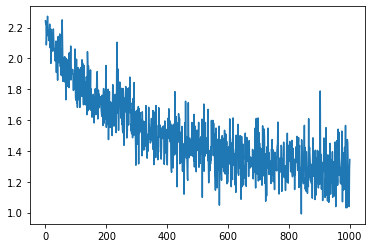

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

# 結果を評価

それぞれのカテゴリの分類がどれほどうまくいっているかを見るために、混合行列を作ります。  
各行に実際のカテゴリ、各列に推測されたカテゴリを当てます。  
混合行列を作るために多くのサンプルをネットワークに入れますが、その際evaluate()を使います。ちなみに逆伝搬の際はtrain()を使います。

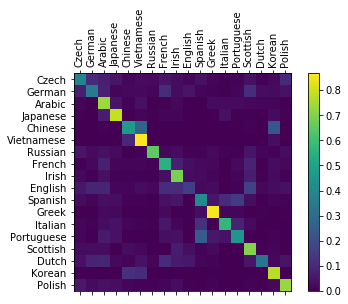

In [32]:
confusion=torch.zeros(n_categories,n_categories)
n_confusion=10000

# 各行に対して出力を得る
def evaluate(line_tensor):
    hidden=rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output,hidden=rnn(line_tensor[i],hidden)
        
    return output

# サンプルを確認し、どれが正しく分類されたかを見る
for i in range(n_confusion):
    category,line,category_tensor,line_tensor=randomTrainingExample()
    output=evaluate(line_tensor)
    guess,guess_i=categoryFromOutput(output)
    category_i=all_categories.index(category)
    confusion[category_i][guess_i]+=1
    
# 合計を各行で割ることで正規化
for i in range(n_categories):
    confusion[i]=confusion[i]/confusion[i].sum()
    
### プロットの準備
fig=plt.figure()
ax=fig.add_subplot(111)
cax=ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([""]+all_categories,rotation=90)
ax.set_yticklabels([""]+all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

明るいところが誤分類の割合が大きいことを表しています。例えば中国語と韓国語などです。

# ユーザーの入力

ユーザーの入力に応じた出力を出します。

In [33]:
def predict(input_line,n_predictions=3):
    print("\n> %s"%input_line)
    
    with torch.no_grad():
        output=evaluate(lineToTensor(input_line))
        
        topv,topi=output.topk(n_predictions,1,True)
        predictions=[]
        
        for i in range(n_predictions):
            value=topv[0][i].item()
            category_index=topi[0][i].item()
            print('(%.2f) %s'%(value,all_categories[category_index]))
            predictions.append([value,all_categories[category_index]])
            
predict("Dovesky")
predict("Jackson")
predict("Satoshi")


> Dovesky
(-0.52) Russian
(-1.30) Czech
(-2.64) English

> Jackson
(-0.05) Scottish
(-3.67) English
(-5.03) Russian

> Satoshi
(-0.68) Japanese
(-1.05) Arabic
(-2.55) Italian
